In [1]:
%matplotlib inline
import math
import time
import numpy as np

In [2]:
import torch

In [3]:
from d2l import torch as d2l

In [4]:
n = 10000 
a = torch.ones(n) 
b = torch.ones(n)

计时器

In [5]:
class Timer: #@save
	"""Record multiple running times."""
	def __init__(self):
		self.times = []
		self.start()
	def start(self):
		"""Start the timer."""
		self.tik = time.time()
	def stop(self):
		"""Stop the timer and record the time in a list."""
		self.times.append(time.time() - self.tik)
		return self.times[-1]
	def avg(self):
		"""Return the average time."""
		return sum(self.times) / len(self.times)
	def sum(self):
		"""Return the sum of time."""
		return sum(self.times)
	def cumsum(self):
		"""Return the accumulated time."""
		return np.array(self.times).cumsum().tolist()

计时器demo

In [7]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.11110 sec'

In [8]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

正态分布

In [9]:
def normal(x, mu, sigma):
	p = 1 / math.sqrt(2 * math.pi * sigma**2)
	return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

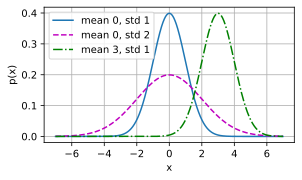

In [10]:
# Use numpy again for visualization
x = np.arange(-7, 7, 0.01)
# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
					ylabel='p(x)', figsize=(4.5, 2.5),
					legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

线性回归的从零开始实现

In [11]:
import random

In [12]:
def synthetic_data(w, b, num_examples): #@save
	"""Generate y = Xw + b + noise."""
	X = torch.normal(0, 1, (num_examples, len(w)))
	y = torch.matmul(X, w) + b
	y += torch.normal(0, 0.01, y.shape)
	return X, y.reshape((-1, 1))

In [13]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [14]:
features[0],labels[0]

(tensor([-0.5250, -0.4721]), tensor([4.7477]))

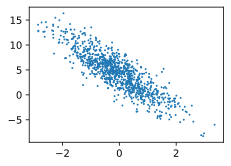

In [15]:
d2l.set_figsize() 
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [16]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]

In [17]:
batch_size = 10

In [19]:
for X, y in data_iter(batch_size, features, labels):
    print(X,'\n',y)
    break

tensor([[ 1.9505, -0.3751],
        [ 1.3807,  0.8133],
        [ 0.7601, -0.2141],
        [-0.1395,  0.6631],
        [-1.8702,  1.4266],
        [ 0.5963,  1.3615],
        [-0.5691, -0.3663],
        [ 2.7328, -1.9648],
        [-0.6023, -0.1543],
        [ 0.0697, -2.8592]]) 
 tensor([[ 9.3728],
        [ 4.1833],
        [ 6.4572],
        [ 1.6653],
        [-4.3841],
        [ 0.7688],
        [ 4.3160],
        [16.3519],
        [ 3.5242],
        [14.0684]])


初始化模型参数

In [21]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) 
b = torch.zeros(1, requires_grad=True)

In [23]:
def linreg(X, w, b): #@save 
    """线性回归模型""" 
    return torch.matmul(X, w) + b

In [24]:
def squared_loss(y_hat, y): #@save 
    """均方损失""" 
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [25]:
def sgd(params, lr, batch_size): #@save
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练

In [26]:
lr = 0.03
num_epochs = 3
net = linreg 
loss = squared_loss

In [27]:
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels) 
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.028549
epoch 2, loss 0.000098
epoch 3, loss 0.000049


In [28]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}') 
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 7.0333e-06, -4.3702e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0003], grad_fn=<RsubBackward1>)
